In [1]:
import cmocean
import cosima_cookbook as cc
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37099,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.13:39395,Total threads: 4
Dashboard: /proxy/41673/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:39897,


# Time mean full period

In [2]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'

time = cc.querying.getvar(easterlies_up, 'eta_global', session, start_time = '2150-01-01', end_time = '2164-12-31').sel(time = slice('2150-01-01', '2164-12-31'))['time']

In [3]:
path_up = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/*'))
path_up

array(['/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc',
       '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_02.nc',
       '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_03.nc',
       '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_04.nc',
       '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_05.nc',
       '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_06.nc',
       '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vo

In [4]:
vol_transp_up = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up)):
    vol_transp_up = xr.concat([vol_transp_up, xr.open_dataset(path_up[i])], dim = 'time')
    
vol_transp_up['time'] = time.values
vol_transp_up_total = (vol_transp_up['vol_trans_across_contour_binned']*vol_transp_up['ndays']).sum('time')/np.sum(vol_transp_up['ndays'])

In [5]:
path_down = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/*'))

vol_transp_do = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')
for i in range(1, len(path_down)):
    vol_transp_do = xr.concat([vol_transp_do, xr.open_dataset(path_down[i])], dim = 'time')
    
vol_transp_do['time'] = time.values
vol_transp_do_total = (vol_transp_do['vol_trans_across_contour_binned']*vol_transp_do['ndays']).sum('time')/np.sum(vol_transp_do['ndays'])

In [6]:
trans_sum_up = vol_transp_up_total.sum('contour_index')
trans_sum_do = vol_transp_do_total.sum('contour_index')

psi_up = trans_sum_up[::-1].cumsum('isopycnal_bins')[::-1]
psi_do = trans_sum_do[::-1].cumsum('isopycnal_bins')[::-1]

In [7]:
# find max DSW density:
DSW_top_density_up = psi_up.argmax()
# sum over DSW layer:
DSW_trans_up = vol_transp_up_total.isel(isopycnal_bins = slice(int(DSW_top_density_up),None)).sum('isopycnal_bins')
DSW_trans_up_cumsum = DSW_trans_up.cumsum('contour_index')/1e6

In [8]:
# find max DSW density:
DSW_top_density_do = psi_do.argmax()
# sum over DSW layer:
DSW_trans_do = vol_transp_do_total.isel(isopycnal_bins = slice(int(DSW_top_density_do),None)).sum('isopycnal_bins')
DSW_trans_do_cumsum = DSW_trans_do.cumsum('contour_index')/1e6

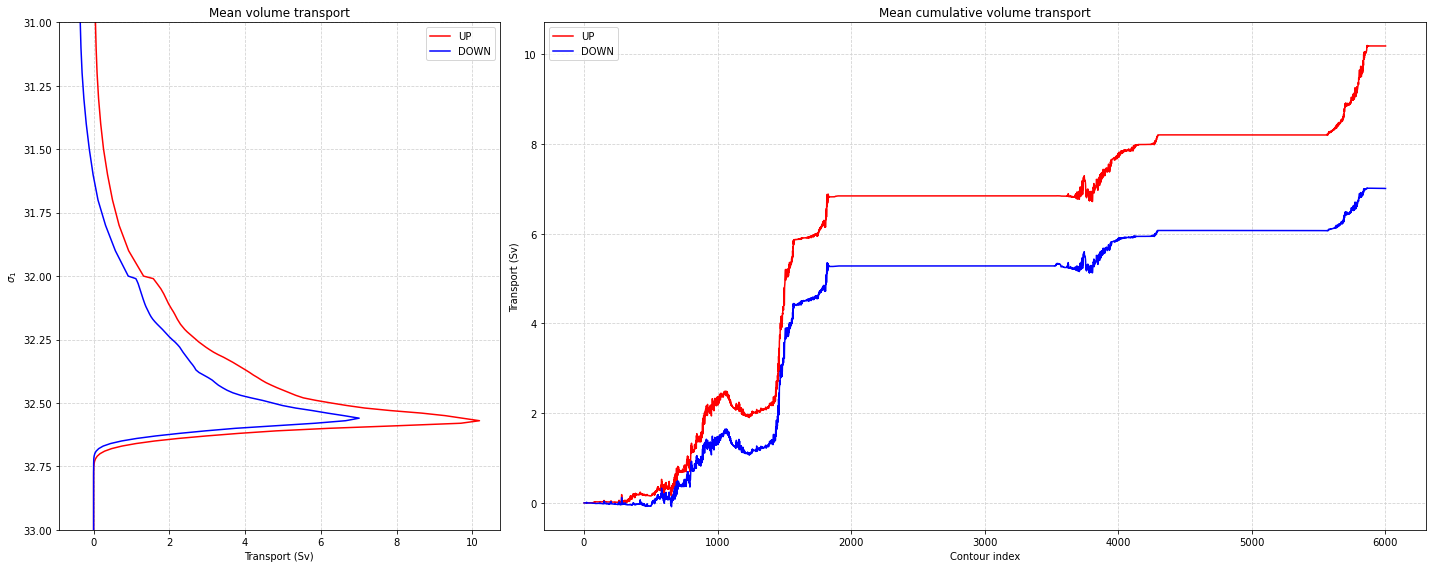

In [8]:
fig = plt.figure(figsize = (20, 8))
grd = gs.GridSpec(1, 2, width_ratios = [0.5, 1])
axs = [fig.add_subplot(grd[0,0]), fig.add_subplot(grd[0,1])]

axs[0].plot(psi_up/1e6, psi_up['isopycnal_bins'], color = 'r', label = 'UP')
axs[0].plot(psi_do/1e6, psi_do['isopycnal_bins'], color = 'b', label = 'DOWN')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylim(33,31)
axs[0].set_xlabel('Transport (Sv)')
axs[0].set_ylabel('$\sigma_1$')
axs[0].legend()
axs[0].set_title('Mean volume transport')

axs[1].plot(DSW_trans_up_cumsum['contour_index'], DSW_trans_up_cumsum, color = 'r', label = 'UP')
axs[1].plot(DSW_trans_do_cumsum['contour_index'], DSW_trans_do_cumsum, color = 'b', label = 'DOWN')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[1].set_xlabel('Contour index')
axs[1].set_ylabel('Transport (Sv)')
axs[1].legend()
axs[1].set_title('Mean cumulative volume transport')

plt.tight_layout()
plt.savefig(figdir+'DSW-export-off-shelf-mean-2150_2164.jpg', bbox_inches = 'tight')

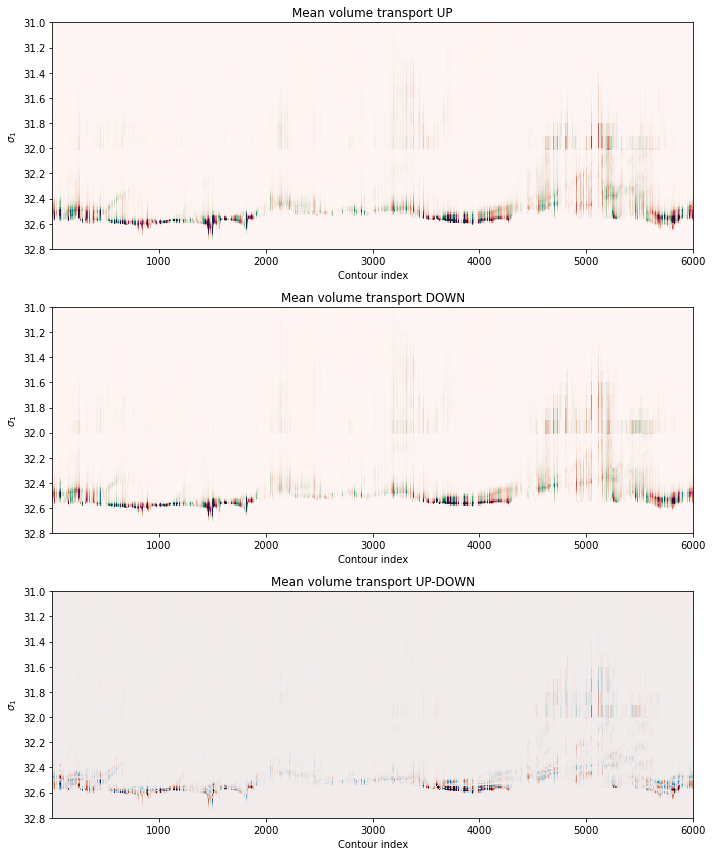

In [9]:
fig = plt.figure(figsize = (10, 12))
grd = gs.GridSpec(3, 1)
axs = [fig.add_subplot(grd[0,0]), fig.add_subplot(grd[1,0]), fig.add_subplot(grd[2,0])]

axs[0].pcolormesh(vol_transp_up_total['contour_index'], vol_transp_up_total['isopycnal_bins'],
                  vol_transp_up_total, cmap = cmocean.cm.curl, vmin = -3e4, vmax = 3e4)
axs[0].set_ylim(32.8,31)
axs[0].set_xlabel('Contour index')
axs[0].set_ylabel('$\sigma_1$')
axs[0].set_title('Mean volume transport UP')

axs[1].pcolormesh(vol_transp_do_total['contour_index'], vol_transp_do_total['isopycnal_bins'],
                  vol_transp_do_total, cmap = cmocean.cm.curl, vmin = -3e4, vmax = 3e4)
axs[1].set_ylim(32.8,31)
axs[1].set_xlabel('Contour index')
axs[1].set_ylabel('$\sigma_1$')
axs[1].set_title('Mean volume transport DOWN')

axs[2].pcolormesh(vol_transp_do_total['contour_index'], vol_transp_do_total['isopycnal_bins'],
                 (vol_transp_up_total-vol_transp_do_total), cmap = cmocean.cm.balance, vmin = -3e4, vmax = 3e4)
axs[2].set_ylim(32.8,31)
axs[2].set_xlabel('Contour index')
axs[2].set_ylabel('$\sigma_1$')
axs[2].set_title('Mean volume transport UP-DOWN')

plt.tight_layout()
plt.savefig(figdir+'DSW-export-off-shelf-mean-2150_2164-colormesh.jpg', bbox_inches = 'tight')

# Time series

In [9]:
vol_transp_up_tv = vol_transp_up['vol_trans_across_contour_binned']
vol_transp_do_tv = vol_transp_do['vol_trans_across_contour_binned']

trans_sum_up_tv = vol_transp_up_tv.sum('contour_index')
trans_sum_do_tv = vol_transp_do_tv.sum('contour_index')

psi_up_tv = trans_sum_up_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_do_tv = trans_sum_do_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]

In [10]:
DSW_export_up = np.empty(len(psi_up_tv['time']))
DSW_export_do = np.empty(len(psi_do_tv['time']))
# find max DSW density:
DSW_top_density_up = psi_up_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_do = psi_do_tv.argmax('isopycnal_bins')

n = 0
for t in time:
    
    # sum over DSW layer:
    DSW_trans_up = psi_up_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_up.sel(time=t)))
    DSW_export_up[n] = DSW_trans_up.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_do = psi_do_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_do.sel(time=t)))
    DSW_export_do[n] = DSW_trans_do.item()/1e6
    n += 1

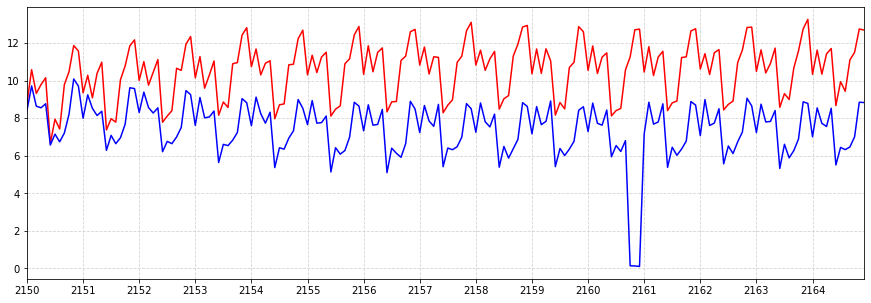

In [11]:
plt.figure(figsize = (15, 5))
plt.plot(np.arange(0, 180, 1), DSW_export_up, color = 'r', label = 'UP')
plt.plot(np.arange(0, 180, 1), DSW_export_do, color = 'b', label = 'DOWN')
plt.xlim(0, 179)
plt.xticks(np.arange(0, 180, 12), np.arange(2150, 2165, 1))
plt.grid(linestyle = '--', color = 'lightgrey')
plt.savefig(figdir+'DSW-export-off-shelf-mean-2150_2164-timeseries.jpg', bbox_inches = 'tight')

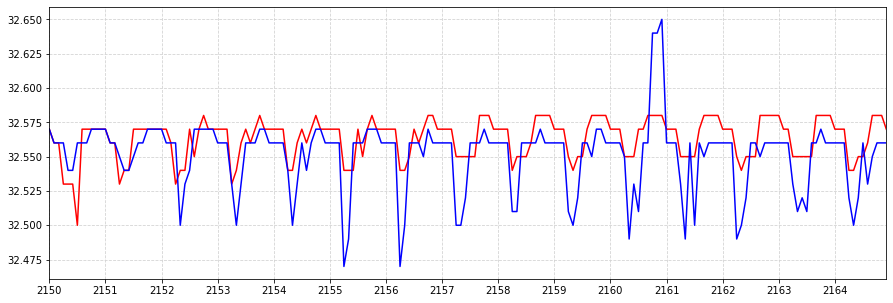

In [12]:
plt.figure(figsize = (15, 5))
plt.plot(np.arange(0, 180, 1), psi_up['isopycnal_bins'][DSW_top_density_up], color = 'r')
plt.plot(np.arange(0, 180, 1), psi_up['isopycnal_bins'][DSW_top_density_do], color = 'b')
plt.xlim(0, 179)
plt.xticks(np.arange(0, 180, 12), np.arange(2150, 2165, 1))
plt.grid(linestyle = '--', color = 'lightgrey')
plt.savefig(figdir+'DSW-export-off-shelf-mean-2150_2164-threshold.jpg', bbox_inches = 'tight')

In [15]:
np.argsort(DSW_export_do)

array([131, 130, 129,  77,  65, 161,  53, 137, 101,  89, 113, 173, 149,
        41, 103, 163,  80, 125, 115, 139,  67, 151,  79,  29, 127, 164,
        68,  17,  91, 175,  55, 116, 140, 104, 114,  78,  90,  54,  66,
       174, 138, 176,  92, 102, 150,  43, 126,   5,  42, 162,  19,  31,
        81, 152,   7,  30, 117, 141, 128,  44, 105, 165,  56,  20,  69,
        93,  32, 177, 168, 144,  18,   6, 132, 108,   8, 156,  84,  45,
        96, 153, 120,  72,  57,  33,  99, 171,  87,  48, 146,  36, 123,
        74, 110,  60,  75,  21, 134, 170, 122,  51,  62, 147,  63, 135,
       158,  98, 159, 111,  86,  12,  38,  39,  64,  15,   9, 100,  50,
        27,  24,  52,  16,  40, 160,   0, 118, 124,  76,  83, 148,  95,
        14,  59, 172, 169,  28,   3,  26, 119, 109, 107,   2,  71, 155,
        85, 143,  73,  88, 157, 136,   4,  94, 167, 121,  97,  47, 106,
       179,  70, 178, 133, 166, 142,  82, 112,  61,  58, 145,  46, 154,
        37,  49,  13,  35,  25,  34,  23,  22,  11,   1,  10])

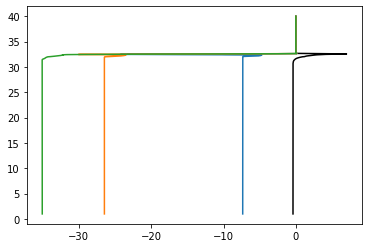

In [22]:
plt.plot(psi_do/1e6, psi_do['isopycnal_bins'], 'k')
for t in [129, 130, 131]:
    plt.plot(psi_do_tv.isel(time=t)/1e6, psi_do_tv['isopycnal_bins'])

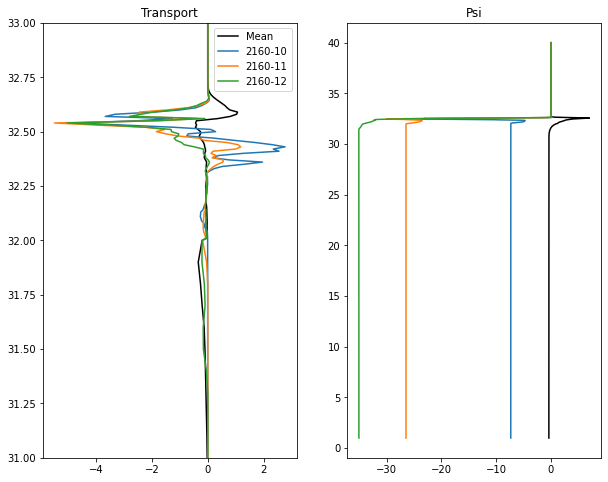

In [48]:
fig = plt.figure(figsize = (10, 8))
grd = gs.GridSpec(1, 2)
axs = [fig.add_subplot(grd[0,0]), fig.add_subplot(grd[0,1])]

axs[0].plot(trans_sum_do/1e6, trans_sum_do['isopycnal_bins'], 'k', label = 'Mean')
axs[1].plot(psi_do/1e6, psi_do['isopycnal_bins'], 'k')

for t, titl in zip([129, 130, 131], ['2160-10', '2160-11', '2160-12']):
    axs[0].plot(trans_sum_do_tv.isel(time=t)/1e6, trans_sum_do_tv['isopycnal_bins'], label = titl)
    axs[1].plot(psi_do_tv.isel(time=t)/1e6, psi_do_tv['isopycnal_bins'])
axs[0].set_ylim(31, 33)
axs[0].set_title('Transport')
axs[1].set_title('Psi')
axs[0].legend()
plt.savefig(figdir+'DSW-export-off-shelf-mean-2150_2164-badones1.jpg', bbox_inches = 'tight')

In [50]:
time[50]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2154, 3, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2154-03-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

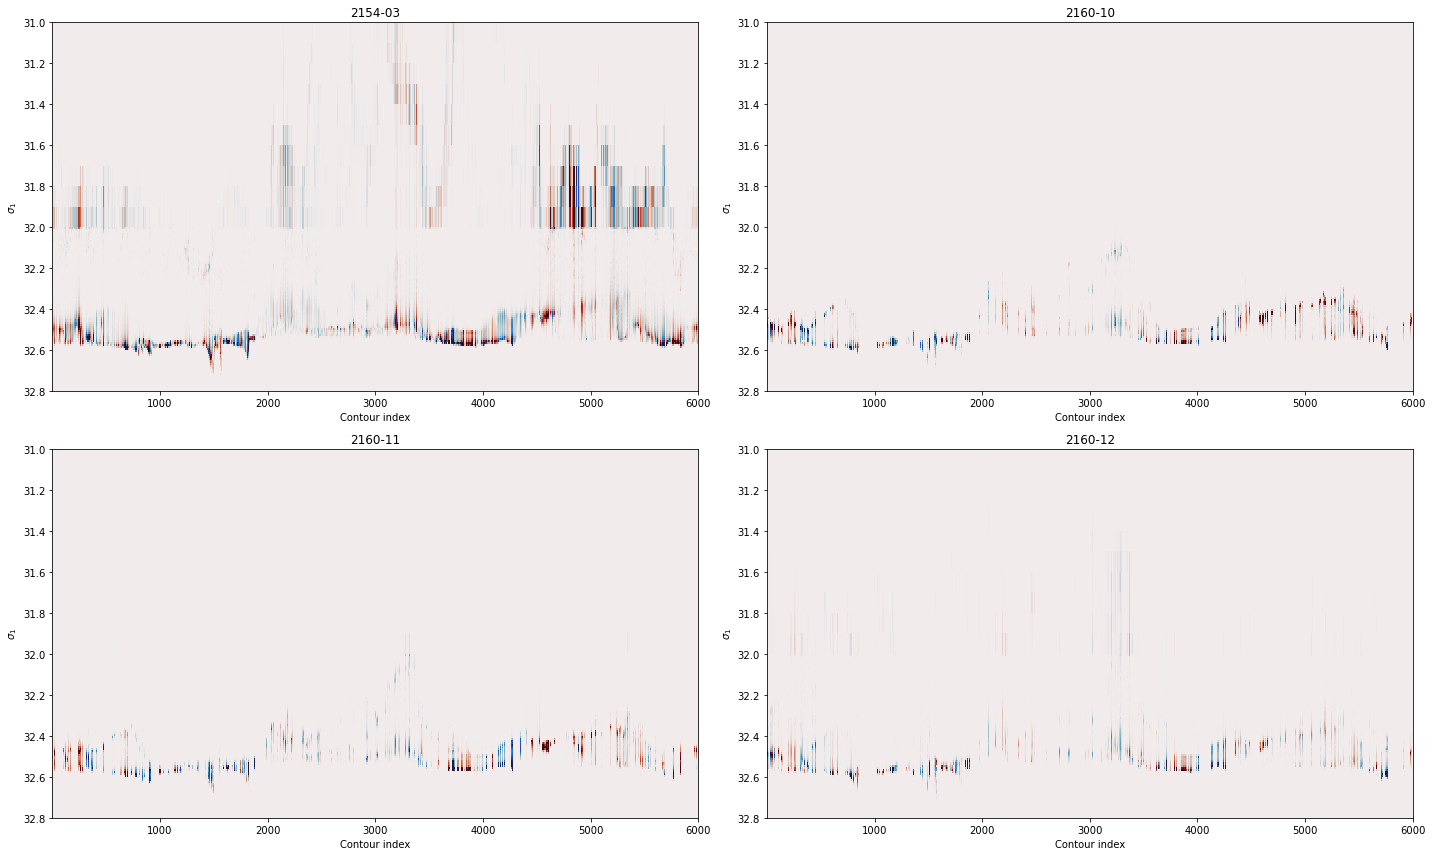

In [51]:
fig = plt.figure(figsize = (20, 12))
grd = gs.GridSpec(2, 2)
axs = [fig.add_subplot(grd[0,0]), fig.add_subplot(grd[0,1]), 
       fig.add_subplot(grd[1,0]), fig.add_subplot(grd[1,1])]

axs[0].pcolormesh(vol_transp_do_tv['contour_index'], vol_transp_do_tv['isopycnal_bins'],
                  vol_transp_do_tv.isel(time = 50), cmap = cmocean.cm.balance, vmin = -3e4, vmax = 3e4)
axs[0].set_ylim(32.8,31)
axs[0].set_xlabel('Contour index')
axs[0].set_ylabel('$\sigma_1$')
axs[0].set_title('2154-03')

n = 1
for t, titl in zip([129, 130, 131], ['2160-10', '2160-11', '2160-12']):
    axs[n].pcolormesh(vol_transp_do_tv['contour_index'], vol_transp_do_tv['isopycnal_bins'],
                      vol_transp_do_tv.isel(time = t), cmap = cmocean.cm.balance, vmin = -3e4, vmax = 3e4)
    axs[n].set_ylim(32.8,31)
    axs[n].set_xlabel('Contour index')
    axs[n].set_ylabel('$\sigma_1$')
    axs[n].set_title(titl); n+=1 

plt.tight_layout()
plt.savefig(figdir+'DSW-export-off-shelf-mean-2150_2164-badones.jpg', bbox_inches = 'tight')